In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

6 ({0, 3, 4}, {1, 2})


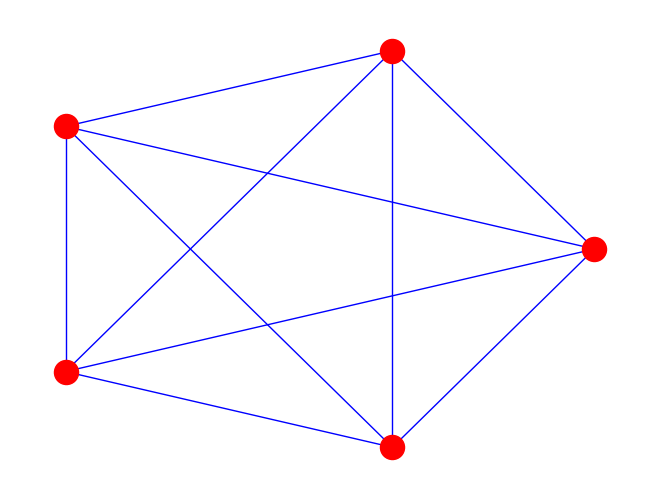

In [2]:
G = nx.complete_graph(5)
cut_size, partition = nx.approximation.randomized_partitioning(G, seed=1)
print(cut_size, partition)
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

In [3]:
g1, g2 = partition
print([(a, b) for idx, a in enumerate(list(g1)) for b in list(g1)[idx + 1:]])
print([(a, b) for idx, a in enumerate(list(g2)) for b in list(g2)[idx + 1:]])

[(0, 3), (0, 4), (3, 4)]
[(1, 2)]


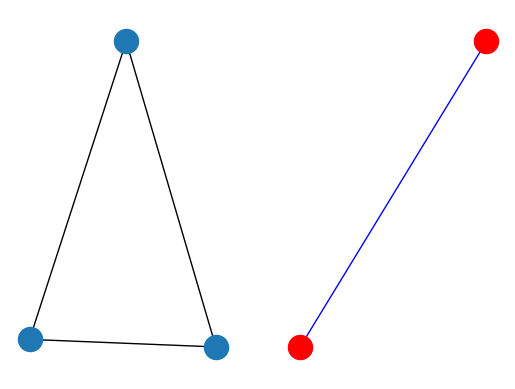

In [4]:
G1 = nx.Graph() 
G2 = nx.Graph()
g1, g2 = partition
G1.add_edges_from([(a, b) for idx, a in enumerate(list(g1)) for b in list(g1)[idx + 1:]])
G2.add_edges_from([(a, b) for idx, a in enumerate(list(g2)) for b in list(g2)[idx + 1:]])
subax1 = plt.subplot(121)
nx.draw(G1)   # default spring_layout
subax2 = plt.subplot(122)
nx.draw(G2, pos=nx.circular_layout(G2), node_color='r', edge_color='b')


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 39
             Gate count: 57
    Nonlocal gate count: 20
         Gate breakdown: RZ: 28, CX: 20, RY: 6, RX: 3


SparsePauliOp(['IZZ', 'ZZI', 'IIZ', 'IZI', 'ZII', 'IIX', 'IXI', 'XII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])


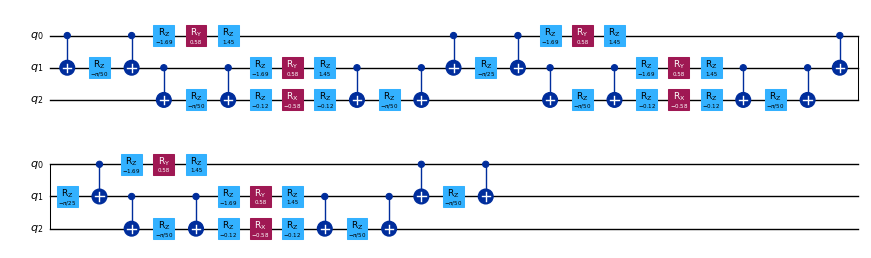

In [5]:
import numpy as np

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.converters import circuit_to_dag

from gate_estimation.cutter_search_manual import *

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

second_order_formula = SuzukiTrotter()

L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(3):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)
print(H)

circuit.draw("mpl", scale=0.5)